In [12]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from numpy import exp, log
import winsound
from scipy.ndimage import shift

In [13]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() 

(X, Y), (X_test, Y_test) = keras.datasets.mnist.load_data()

one_hot = np.zeros((len(Y), 10))
one_hot_test = np.zeros((len(Y_test), 10))

for i, label in enumerate(Y):
    one_hot[i][label] = 1

for i, label in enumerate(Y_test):
    one_hot_test[i][label] = 1

Y = one_hot
Y_test = one_hot_test

X, X_val, Y, Y_val = train_test_split(X, Y, test_size=0.2, random_state=44)

In [21]:
def build_model(learning_rate=3e-3, input_shape=(28, 28, 1), l2_lambda=0.01, dropout_rate=0.3):
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
        keras.layers.Conv2D(8, (3, 3), kernel_regularizer=keras.regularizers.l2(l2_lambda)),
        keras.layers.Activation("relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Conv2D(32, (3, 3), kernel_regularizer=keras.regularizers.l2(l2_lambda)),
        keras.layers.Activation("relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax", kernel_regularizer=keras.regularizers.l2(l2_lambda))
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    return model

In [16]:
class LRFinder(keras.callbacks.Callback):
    def __init__(self, start_lr=1e-5, end_lr=1e-1, num_iterations=50, max_loss=300):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iterations = num_iterations
        self.learning_rates = []
        self.losses = []
        self.iteration = 0
        self.multiplier = (end_lr/start_lr)**(1/num_iterations)
        self.max_loss = max_loss

    def on_train_batch_begin(self, batch, logs=None):
        lr = self.start_lr * (self.multiplier ** self.iteration)
        self.model.optimizer.learning_rate.assign(lr)
        self.learning_rates.append(lr)

    def on_train_batch_end(self, batch, logs=None):
        loss = logs['loss']
        if not np.isnan(loss) and loss < self.max_loss:
            self.losses.append(loss)
        else:
            self.losses.append(None)
        self.iteration += 1
        if self.iteration >= self.num_iterations:
            self.model.stop_training = True

    def plot_loss(self):
        valid_losses = [loss for loss in self.losses if loss is not None]
        valid_learning_rates = [lr for lr, loss in zip(self.learning_rates, self.losses) if loss is not None]
        
        plt.figure(figsize=(10, 6))
        plt.plot(valid_learning_rates, valid_losses)
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate vs. Loss')
        
        min_loss_idx = np.argmin(valid_losses)
        
        optimal_lr = valid_learning_rates[min_loss_idx] / 10
        
        plt.axvline(x=optimal_lr, color='red', linestyle='--', label=f'Optimal LR: {optimal_lr:.2e}')
        plt.legend()
        
        plt.show()


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2380 - loss: 6.6148 - val_accuracy: 0.8415 - val_loss: 0.8001
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7720 - loss: 0.9854 - val_accuracy: 0.8654 - val_loss: 1.9830
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5522 - loss: nan - val_accuracy: 0.0962 - val_loss: nan
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0996 - loss: nan - val_accuracy: 0.0962 - val_loss: nan


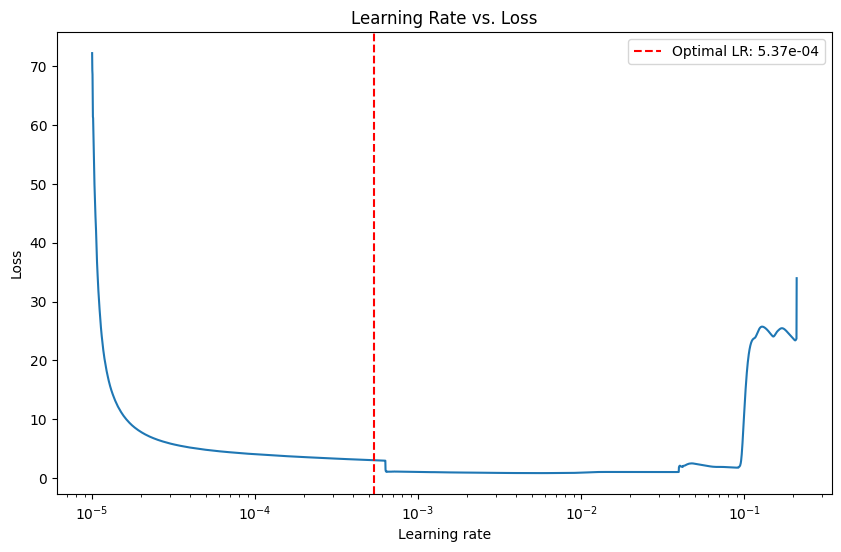

In [17]:
lr_finder = LRFinder(start_lr=1e-5, end_lr=10, num_iterations=5000)

model = build_model()

model.fit(X, Y, epochs=5, validation_data=(X_val, Y_val), callbacks=[lr_finder])

lr_finder.plot_loss()

In [27]:
model = build_model(learning_rate=5e-3)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

checkpoint = keras.callbacks.ModelCheckpoint("mnist_keras.keras", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X, Y, epochs=300, validation_data=(X_val, Y_val), batch_size=256,
              callbacks=[checkpoint, tensorboard_cb, lr_scheduler,
                          keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(Y_test, axis=1)
accuracy = np.mean(predicted_classes == true_classes)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
winsound.Beep(2500, 2000)

Epoch 1/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5282 - loss: 10.2651 - val_accuracy: 0.9419 - val_loss: 0.5155 - learning_rate: 0.0050
Epoch 2/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9044 - loss: 0.5830 - val_accuracy: 0.9628 - val_loss: 0.3566 - learning_rate: 0.0050
Epoch 3/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9347 - loss: 0.4217 - val_accuracy: 0.9710 - val_loss: 0.2749 - learning_rate: 0.0050
Epoch 4/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9441 - loss: 0.3420 - val_accuracy: 0.9695 - val_loss: 0.2478 - learning_rate: 0.0050
Epoch 5/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9459 - loss: 0.3092 - val_accuracy: 0.9725 - val_loss: 0.2110 - learning_rate: 0.0050
Epoch 6/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9503 - loss: 0.2763 - val_accuracy: 0.9740 - val_loss: 0.1932 - learning_rate: 0.0050
Epoch 7/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9542 - 